In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

In [26]:
df = pd.read_csv('../data/fresno_eda.csv', index_col='datetime', parse_dates=True)
df.head()

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,conditions,description,icon,stations,clear-day,cloudy,fog,partly-cloudy-day,rain_icon,wind
datetime,,,,,,,,,,,,,,,,,,,,,
1992-01-01,Fresno California,57.6,34.1,44.5,57.6,34.1,43.2,40.1,85.6,0.000,...,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"74702023110,72389093193",0,0,0,1,0,0
1992-01-02,Fresno California,46.1,39.9,42.6,44.9,35.5,40.0,41.0,93.8,0.000,...,Overcast,Cloudy skies throughout the day.,fog,"74702023110,72389093193",0,0,1,0,0,0
1992-01-03,Fresno California,52.1,41.2,46.8,52.1,36.8,45.3,43.6,88.8,0.083,...,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"74702023110,72389093193",0,0,0,0,1,0
1992-01-04,Fresno California,59.2,44.1,51.8,59.2,41.2,50.8,45.1,78.8,0.000,...,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"74702023110,72389093193",0,0,0,1,0,0
1992-01-05,Fresno California,56.8,44.9,48.1,56.8,36.6,45.4,43.1,83.7,1.016,...,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"74702023110,72389093193",0,0,0,0,1,0


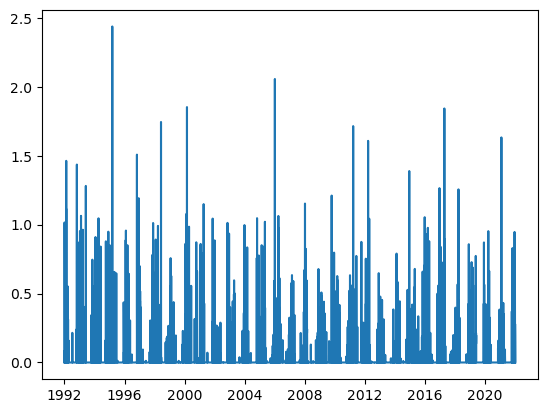

In [27]:
plt.plot(df['precip'])

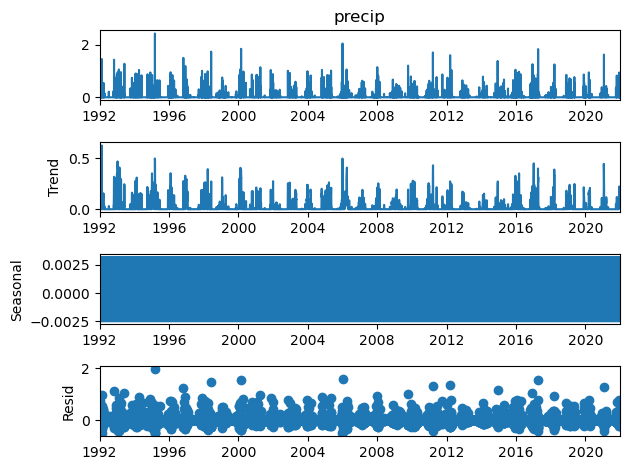

In [28]:

# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df['precip'])

# Plot the decomposed time series.
decomp.plot();

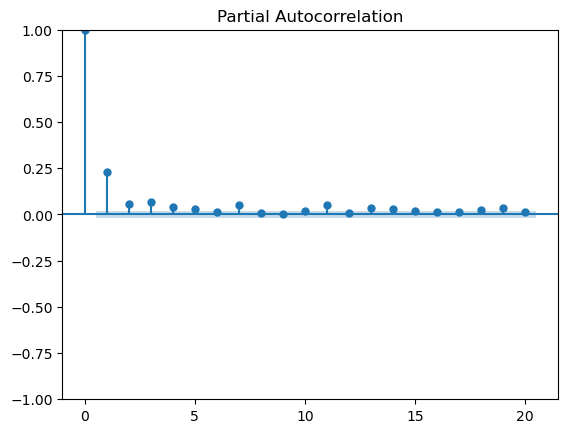

In [29]:
plot_pacf(df['precip'], lags=20, method='ywm');

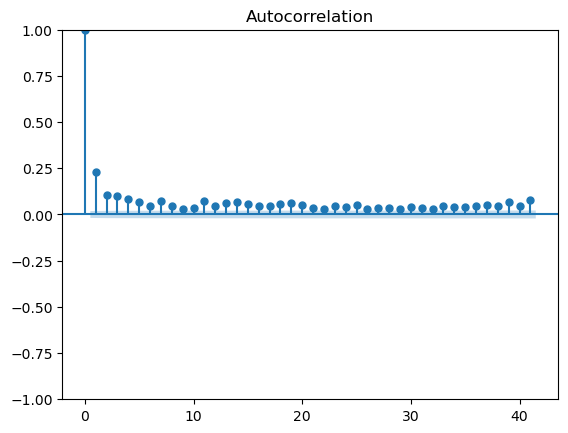

In [30]:
plot_acf(df['precip']);

In [31]:
df = df.groupby(df.index)[['precip']].sum()

df

,precip
datetime,
1992-01-01,0.000
1992-01-02,0.000
1992-01-03,0.083
1992-01-04,0.000
1992-01-05,1.016
...,...
2021-12-28,0.011
2021-12-29,0.199
2021-12-30,0.000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10959 entries, 1992-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  10959 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


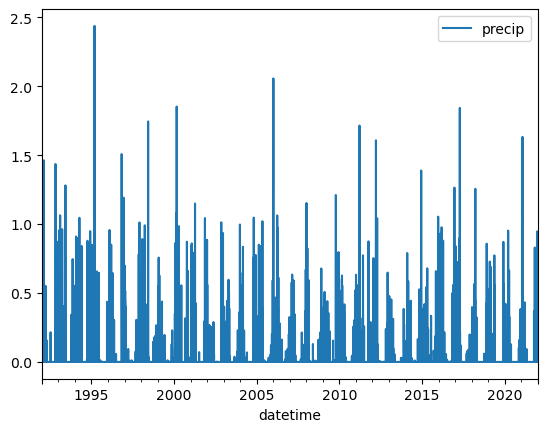

In [33]:
df.plot();

In [38]:
train = df.loc[:'2016-01-01']

In [39]:
test = df.loc['2016-02-01':]

In [40]:
train.shape, test.shape

((8767, 1), (2162, 1))

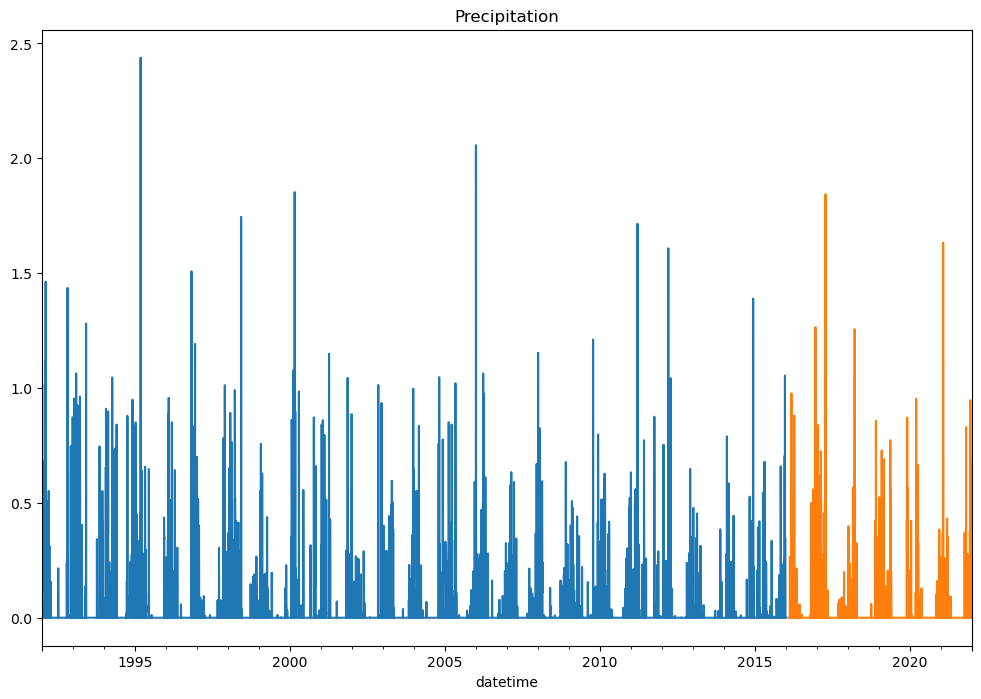

In [41]:
train['precip'].plot()
test['precip'].plot(figsize = (12, 8), title = 'Precipitation');

In [42]:
df_preds = test.copy()

In [46]:
train.index.freq = 'D'

In [48]:
train

,precip
datetime,
1992-01-01,0.000
1992-01-02,0.000
1992-01-03,0.083
1992-01-04,0.000
1992-01-05,1.016
...,...
2015-12-28,0.000
2015-12-29,0.000
2015-12-30,0.000


In [54]:
hw = ExponentialSmoothing(train['precip'], trend='add', seasonal='add').fit()

In [55]:
hw.summary()

Dep. Variable:,precip,No. Observations:,8767
Model:,ExponentialSmoothing,SSE,140.964
Optimized:,True,AIC,-36187.853
Trend:,Additive,BIC,-36109.987
Seasonal:,Additive,AICC,-36187.811
Seasonal Periods:,7,Date:,"Tue, 22 Aug 2023"
Box-Cox:,False,Time:,23:14:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0502394,alpha,True
smoothing_trend,0.000000,beta,True


In [56]:
df_preds['hw'] = hw.forecast(len(test))

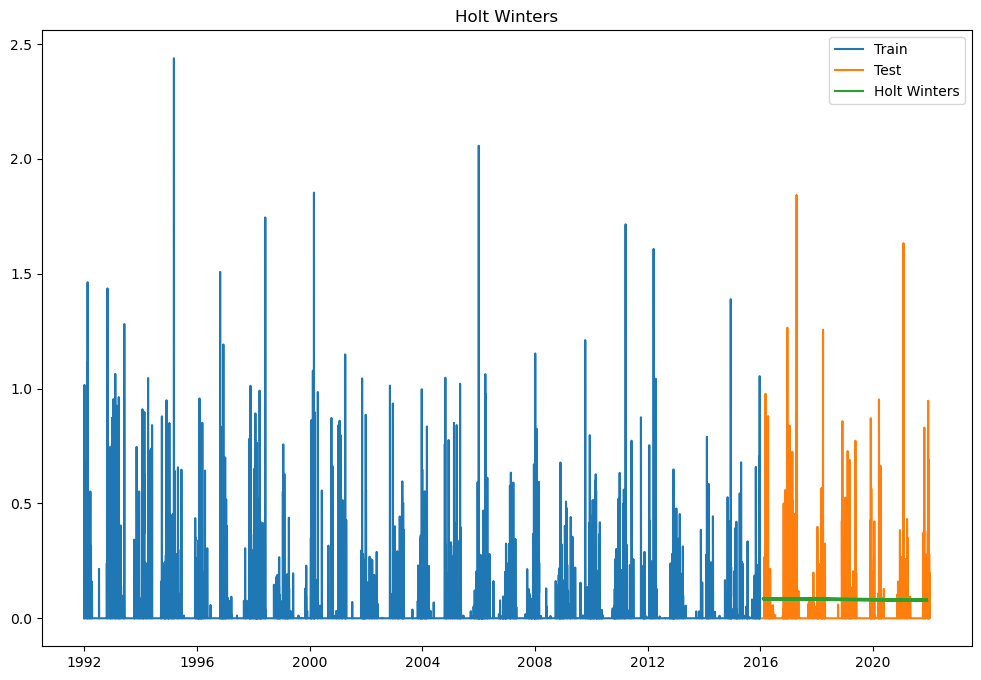

In [57]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train['precip'], label = 'Train')
plt.plot(test.index, test['precip'], label = 'Test')
plt.plot(df_preds.index, df_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.title('Holt Winters');